#### The CrisisMMD multimodal Twitter dataset consists of several thousands of manually annotated tweets and images collected during seven major natural disasters

#### Task 1: Informative vs Not informative
* Informative
* Not informative

#### Task 2: Humanitarian categories
* Affected individuals
* Infrastructure and utility damage
* Injured or dead people
* Missing or found people
* Rescue, volunteering or donation effort
* Vehicle damage
* Other relevant information
* Not humanitarian
   
#### Task 3: Damage severity assessment
* Severe damage
* Mild damage
* Little or no damage

Each TSV file in this directory contains the following columns, separated by a tab:

* tweet_id: corresponds to the actual tweet id from Twitter.
* image_id: corresponds to a combination of a "tweet_id" and an index concatenated with an underscore. The integer indices represent different images associated with a given tweet.
* text_info: corresponds to the informative label (i.e., informative, not_informative, dont_know_or_cant_judge) assigned to a given tweet text.
* text_info_conf: corresponds to the confidence score associated with the "text_info" label of a given tweet text.
* image_info: corresponds to the informative label (i.e., informative, not_informative, dont_know_or_cant_judge) assigned to a given tweet image.
* image_info_conf: corresponds to the confidence score associated with the "image_info" label  of a given tweet image.
* text_human: corresponds to the humanitarian label (see the list of humanitarian task labels above) assigned to a given tweet text.
* text_human_conf: corresponds to the confidence score associated with the "text_human" label of a given tweet text.
* image_human: corresponds to the humanitarian label (see the list of humanitarian task labels above) assigned to a given tweet image.
* image_human_conf: corresponds to the confidence score associated with the "image_human" label of a given tweet image.
* image_damage: corresponds to the damage severity assessment label (see the list of damage severity assessment task labels above) assigned to a given tweet image.
* image_damage_conf: corresponds to the confidence score associated with the "image_damage" label of a given tweet image.
* tweet_text: corresponds to the original text of a given tweet as downloaded from Twitter.
* image_url: corresponds to the original image URL of a given tweet provided by Twitter.
* image_path: corresponds to the relative path of an image inside the "data_image" folder for a given tweet.

Note that there are empty (i.e., null) entries in the TSV files that simply indicate "not applicable" cases. For example, for a given pair of tweet text and image, if neither the text nor the image is labeled as informative (i.e., text_info != informative & image_info != informative), then the given tweet text/image pair is excluded from the rest of the annotation tasks (i.e., humanitarian and damage severity assessment tasks). Similarly, for the damage severity assessment task, we included only the subset of images that were labeled as "infrastructure and utility damage" and excluded all other images from the task. In such cases, we have empty (i.e., null) entries in our annotation tables.


In [1]:
import pandas as pd
import numpy as np

In [2]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly

In [3]:
import textblob
import tweepy
from textblob import TextBlob
import os
import nltk
import re
import string
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
#Load into dataframe
dataset = pd.read_csv("iraq_iran_earthquake_final_data.tsv", sep='\t')

In [6]:
print("The dataset has", dataset.shape[1], "variables describing", dataset.shape[0],"tuples")

The dataset has 15 variables describing 597 tuples


In [7]:
dataset.head()

,tweet_id,image_id,text_info,text_info_conf,image_info,image_info_conf,text_human,text_human_conf,image_human,image_human_conf,image_damage,image_damage_conf,tweet_text,image_url,image_path
0,929989361453621249,929989361453621249_0,informative,1.0000,informative,0.6513,injured_or_dead_people,1.0000,other_relevant_information,0.6513,NaN,NaN,RT @PressTV: UPDATE: Death toll from Iran’s qu...,http://pbs.twimg.com/media/DOfT-eRWkAAJ_kB.jpg,data_image/iraq_iran_earthquake/13_11_2017/929...
1,929989388863508480,929989388863508480_0,not_informative,0.7535,not_informative,1.0000,not_humanitarian,0.7535,not_humanitarian,1.0000,NaN,NaN,RT @CAFOD: We pray for all those affected by t...,http://pbs.twimg.com/media/DOftf6AW0AAzjkE.jpg,data_image/iraq_iran_earthquake/13_11_2017/929...
2,929989414826024960,929989414826024960_0,informative,1.0000,not_informative,1.0000,injured_or_dead_people,1.0000,not_humanitarian,1.0000,NaN,NaN,RT @ReutersWorld: JUST IN: Death toll reaches ...,http://pbs.twimg.com/media/DOf76fBUMAAqpv_.jpg,data_image/iraq_iran_earthquake/13_11_2017/929...
3,929989443913691136,929989443913691136_0,informative,1.0000,informative,0.6031,other_relevant_information,1.0000,injured_or_dead_people,0.6031,NaN,NaN,RT @LaylaAlhussein: A magnitude 7.2 earthquake...,http://pbs.twimg.com/media/DOeoQ75XUAEpZwN.jpg,data_image/iraq_iran_earthquake/13_11_2017/929...
4,929989443913691136,929989443913691136_1,informative,1.0000,informative,1.0000,other_relevant_information,1.0000,rescue_volunteering_or_donation_effort,1.0000,NaN,NaN,RT @LaylaAlhussein: A magnitude 7.2 earthquake...,http://pbs.twimg.com/media/DOeoQ75WAAIsov_.jpg,data_image/iraq_iran_earthquake/13_11_2017/929...


In [8]:
dataset.shape

(597, 15)

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 597 entries, 0 to 596
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tweet_id           597 non-null    int64  
 1   image_id           597 non-null    object 
 2   text_info          597 non-null    object 
 3   text_info_conf     597 non-null    float64
 4   image_info         597 non-null    object 
 5   image_info_conf    597 non-null    float64
 6   text_human         597 non-null    object 
 7   text_human_conf    597 non-null    float64
 8   image_human        597 non-null    object 
 9   image_human_conf   597 non-null    float64
 10  image_damage       173 non-null    object 
 11  image_damage_conf  173 non-null    float64
 12  tweet_text         597 non-null    object 
 13  image_url          597 non-null    object 
 14  image_path         597 non-null    object 
dtypes: float64(5), int64(1), object(9)
memory usage: 70.1+ KB


The variables are a mix of **categorical** and **continuous** types.

There is a memory usage of 186 KB for the entire dataset.

In [10]:
dataset.sample(5)

,tweet_id,image_id,text_info,text_info_conf,image_info,image_info_conf,text_human,text_human_conf,image_human,image_human_conf,image_damage,image_damage_conf,tweet_text,image_url,image_path
587,931691151236780037,931691151236780037_0,informative,1.0000,informative,1.0000,other_relevant_information,1.0000,other_relevant_information,1.0000,NaN,NaN,The 2017 Iran-Iraq Earthquake from Sentinel-1....,http://pbs.twimg.com/media/DO4IJwsW0AAujG9.jpg,data_image/iraq_iran_earthquake/18_11_2017/931...
1,929989388863508480,929989388863508480_0,not_informative,0.7535,not_informative,1.0000,not_humanitarian,0.7535,not_humanitarian,1.0000,NaN,NaN,RT @CAFOD: We pray for all those affected by t...,http://pbs.twimg.com/media/DOftf6AW0AAzjkE.jpg,data_image/iraq_iran_earthquake/13_11_2017/929...
496,930857540954574851,930857540954574851_0,not_informative,0.6698,not_informative,0.6364,not_humanitarian,0.6698,not_humanitarian,0.6364,NaN,NaN,#Iran Turned Down Israeli Aid Offer After Eart...,http://pbs.twimg.com/media/DOsR__RW0AY22mi.jpg,data_image/iraq_iran_earthquake/15_11_2017/930...
273,930151625032740865,930151625032740865_1,informative,0.6943,not_informative,1.0000,rescue_volunteering_or_donation_effort,0.6943,not_humanitarian,1.0000,NaN,NaN,Big earthquake in my Iran. Help them to stand ...,http://pbs.twimg.com/media/DOiP9-YX4AAwhvu.jpg,data_image/iraq_iran_earthquake/13_11_2017/930...
382,930401239002701825,930401239002701825_0,informative,0.6355,informative,0.6471,other_relevant_information,0.6355,injured_or_dead_people,0.6471,NaN,NaN,No action from Iran government and other count...,http://pbs.twimg.com/media/DOly_UXWsAEidVq.jpg,data_image/iraq_iran_earthquake/14_11_2017/930...


In [11]:
dataset.drop(['tweet_id','image_id','image_url','image_path'], axis = 1, inplace = True) #dropping key column, it's unnecessary for  the analysis and prediction

In [12]:
categorical = [col for col in dataset.columns if dataset.dtypes[col] =='object']
numericals  = [col for col in dataset.columns if dataset.dtypes[col] !='object']
print("No of categorical features are: ",len(categorical),"\nNo of numerical features are: ",len(numericals))

No of categorical features are:  6 
No of numerical features are:  5


In [13]:
# function to describe the field dtype, missing and unique values
def description(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['Sample Value 1'] = df.iloc[0].values
    summary['Sample Value 2'] = df.iloc[1].values
    return summary

description(dataset)

,Name,dtypes,Missing,Uniques,Sample Value 1,Sample Value 2
0,text_info,object,0,2,informative,not_informative
1,text_info_conf,float64,0,136,1.0,0.7535
2,image_info,object,0,2,informative,not_informative
3,image_info_conf,float64,0,152,0.6513,1.0
4,text_human,object,0,6,injured_or_dead_people,not_humanitarian
5,text_human_conf,float64,0,136,1.0,0.7535
6,image_human,object,0,8,other_relevant_information,not_humanitarian
7,image_human_conf,float64,0,152,0.6513,1.0
8,image_damage,object,424,3,NaN,NaN
9,image_damage_conf,float64,424,41,NaN,NaN


In [14]:
dataset.describe()

,text_info_conf,image_info_conf,text_human_conf,image_human_conf,image_damage_conf
count,597.000000,597.000000,597.000000,597.000000,173.000000
mean,0.849300,0.839658,0.849300,0.839658,0.878654
std,0.186429,0.195522,0.186429,0.195522,0.162239
min,0.335800,0.336100,0.335800,0.336100,0.345400
25%,0.670300,0.669800,0.670300,0.669800,0.736700
50%,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


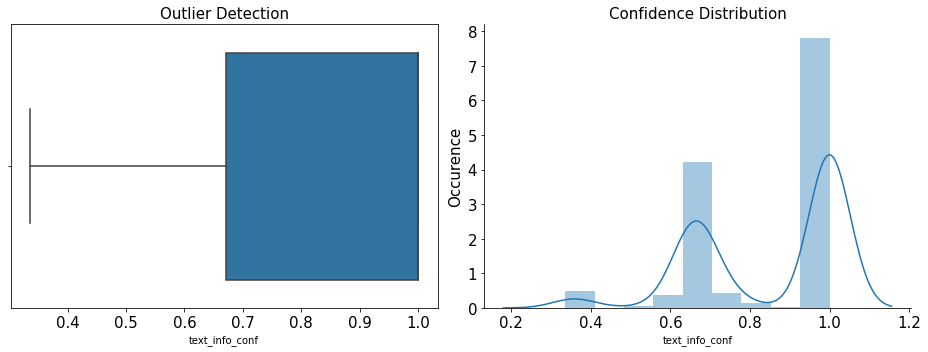

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))
sns.boxplot(x = 'text_info_conf', data = dataset, orient = 'v', ax = ax1)
ax1.set_title('Outlier Detection', fontsize=15)
ax1.tick_params(labelsize=15)

sns.distplot(dataset['text_info_conf'], ax = ax2)
sns.despine(ax = ax2)
ax2.set_ylabel('Occurence', fontsize=15)
ax2.set_title('Confidence Distribution', fontsize=15)
ax2.tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout() 


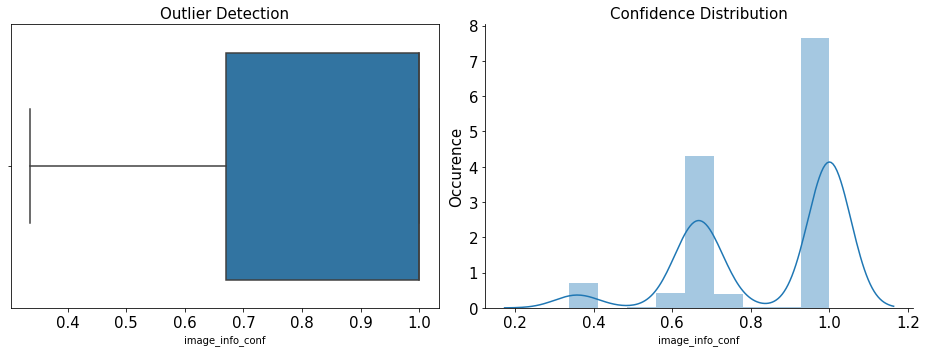

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))
sns.boxplot(x = 'image_info_conf', data = dataset, orient = 'v', ax = ax1)
ax1.set_title('Outlier Detection', fontsize=15)
ax1.tick_params(labelsize=15)

sns.distplot(dataset['image_info_conf'], ax = ax2)
sns.despine(ax = ax2)
ax2.set_ylabel('Occurence', fontsize=15)
ax2.set_title('Confidence Distribution', fontsize=15)
ax2.tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout() 


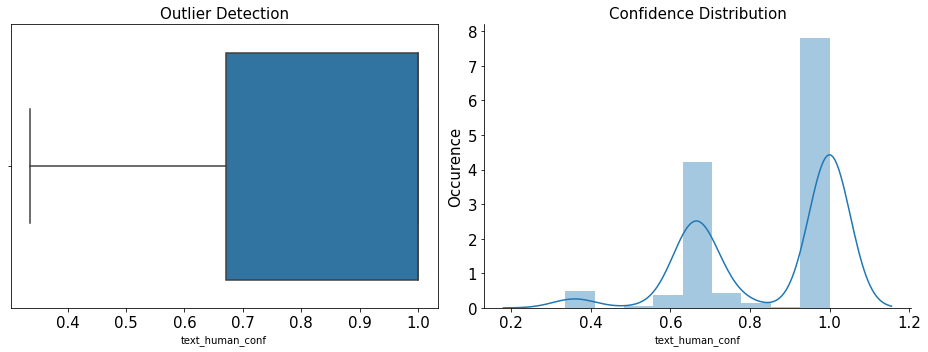

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))
sns.boxplot(x = 'text_human_conf', data = dataset, orient = 'v', ax = ax1)
ax1.set_title('Outlier Detection', fontsize=15)
ax1.tick_params(labelsize=15)

sns.distplot(dataset['text_human_conf'], ax = ax2)
sns.despine(ax = ax2)
ax2.set_ylabel('Occurence', fontsize=15)
ax2.set_title('Confidence Distribution', fontsize=15)
ax2.tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout() 


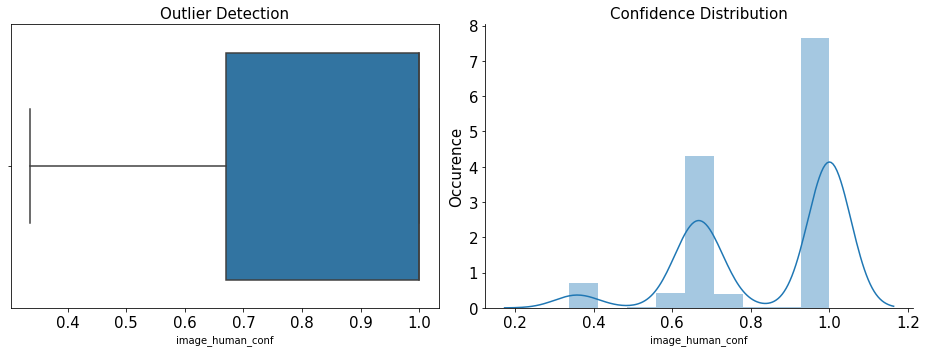

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))
sns.boxplot(x = 'image_human_conf', data = dataset, orient = 'v', ax = ax1)
ax1.set_title('Outlier Detection', fontsize=15)
ax1.tick_params(labelsize=15)

sns.distplot(dataset['image_human_conf'], ax = ax2)
sns.despine(ax = ax2)
ax2.set_ylabel('Occurence', fontsize=15)
ax2.set_title('Confidence Distribution', fontsize=15)
ax2.tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout() 


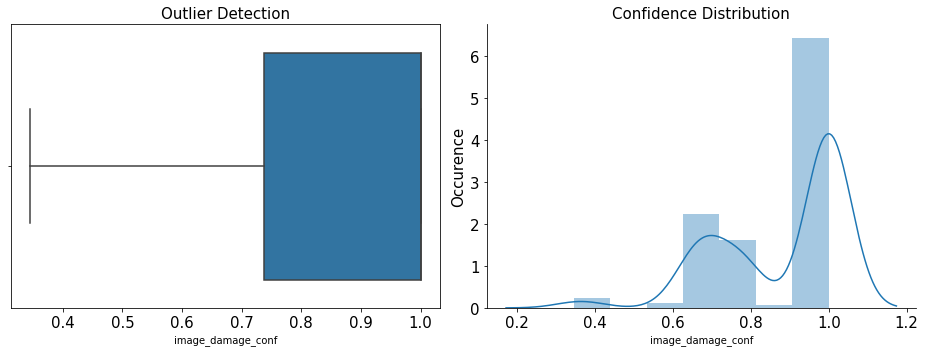

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))
sns.boxplot(x = 'image_damage_conf', data = dataset, orient = 'v', ax = ax1)
ax1.set_title('Outlier Detection', fontsize=15)
ax1.tick_params(labelsize=15)

sns.distplot(dataset['image_damage_conf'], ax = ax2)
sns.despine(ax = ax2)
ax2.set_ylabel('Occurence', fontsize=15)
ax2.set_title('Confidence Distribution', fontsize=15)
ax2.tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout() 


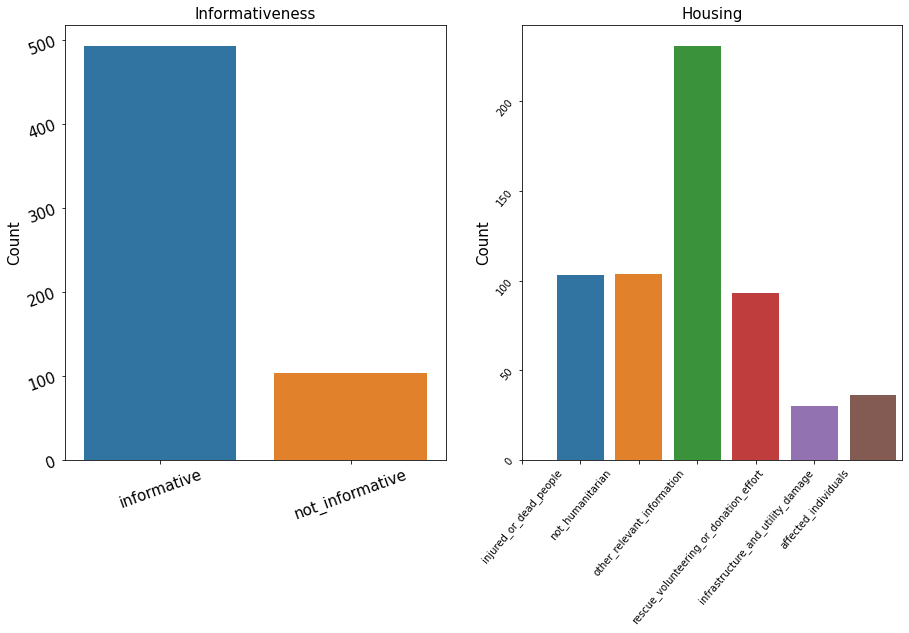

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15,8))
sns.countplot(x = 'text_info', data = dataset, ax = ax1)
ax1.set_title('Informativeness', fontsize=15)
ax1.set_xlabel('')
ax1.set_ylabel('Count', fontsize=15)
ax1.set_xticks(range(len(dataset.text_info.unique())))
ax1.tick_params(labelsize=15,rotation=20)


sns.countplot(x = 'text_human', data = dataset, ax = ax2)
ax2.set_title('Housing', fontsize=15)
ax2.set_xlabel('')
ax2.set_ylabel('Count', fontsize=15)
ax2.set_xticks([-1,0,1,2,3,4])
ax2.set_xticklabels(dataset.text_human.unique())

ax2.tick_params(labelsize=10,rotation=50)

plt.subplots_adjust()

In [21]:
categorical.pop()
for i in categorical:
    print(i,"has following categories with counts as follows")
    print(dataset[i].value_counts(),"\n\n")

text_info has following categories with counts as follows
informative        493
not_informative    104
Name: text_info, dtype: int64 


image_info has following categories with counts as follows
informative        400
not_informative    197
Name: image_info, dtype: int64 


text_human has following categories with counts as follows
other_relevant_information                231
not_humanitarian                          104
injured_or_dead_people                    103
rescue_volunteering_or_donation_effort     93
affected_individuals                       36
infrastructure_and_utility_damage          30
Name: text_human, dtype: int64 


image_human has following categories with counts as follows
not_humanitarian                          197
infrastructure_and_utility_damage         173
other_relevant_information                 72
injured_or_dead_people                     63
rescue_volunteering_or_donation_effort     44
affected_individuals                       38
vehicle_damage     

In [22]:
twitter = pd.DataFrame(columns=['tweets'])
twitter['tweets'] = dataset['tweet_text']

In [23]:
twitter.tweets.drop_duplicates(inplace = True)
type(twitter.tweets)

pandas.core.series.Series

In [24]:
stopwords = set(STOPWORDS)
wc = WordCloud(max_font_size=50, max_words=100, background_color="black",stopwords = stopwords).generate(str(twitter['tweets']))

(-0.5, 399.5, 199.5, -0.5)

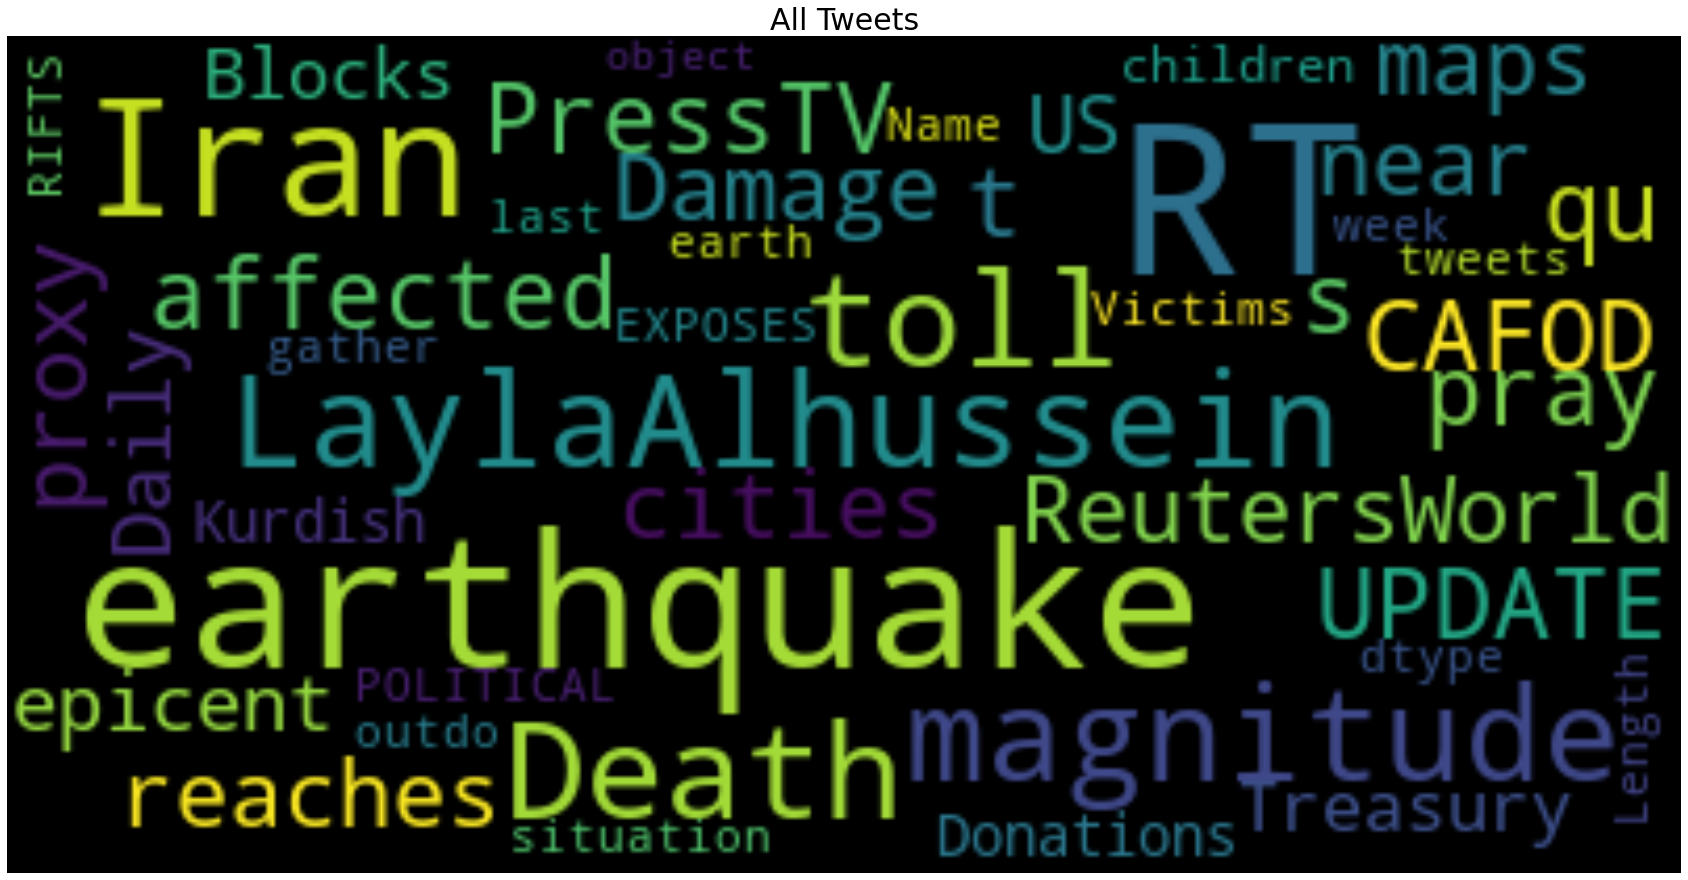

In [25]:
plt.figure(figsize=(30,30))
plt.imshow(wc, interpolation='bilinear')
plt.title('All Tweets', fontsize=30)
plt.axis('off')

In [26]:
#Removing Punctuation
def remove_punct(text):
    text = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0–9]+', '', text)
    return text

twitter['clean_text'] = twitter['tweets'].apply(lambda x: remove_punct(x))

#Appliyng tokenization
def tokenization(text):
    text = re.split('\W+', text)
    return text

twitter['clean_text'] = twitter['clean_text'].apply(lambda x: tokenization(x.lower()))

#Removing stopwords
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
twitter['clean_text'] = twitter['clean_text'].apply(lambda x: remove_stopwords(x))

#Appliyng Stemmer
ps = nltk.PorterStemmer()
def stemming(text):
    text = [ps.stem(word) for word in text]
    return text
twitter['clean_text'] = twitter['clean_text'].apply(lambda x: stemming(x))


In [27]:
twitter

,tweets,clean_text
0,RT @PressTV: UPDATE: Death toll from Iran’s qu...,"[rt, presstv, updat, death, toll, iran, quak, ..."
1,RT @CAFOD: We pray for all those affected by t...,"[rt, cafod, pray, affect, earthquak, iraq, ira..."
2,RT @ReutersWorld: JUST IN: Death toll reaches ...,"[rt, reutersworld, death, toll, reach, 328, ir..."
3,RT @LaylaAlhussein: A magnitude 7.2 earthquake...,"[rt, laylaalhussein, magnitud, 72, earthquak, ..."
4,RT @LaylaAlhussein: A magnitude 7.2 earthquake...,"[rt, laylaalhussein, magnitud, 72, earthquak, ..."
...,...,...
592,Damage proxy maps of 5 cities near the epicent...,"[damag, proxi, map, 5, citi, near, epicent, ke..."
593,#Iran Daily: US Treasury Blocks Donations for ...,"[iran, daili, us, treasuri, block, donat, eart..."
594,#Kurdish children's situation after the #earth...,"[kurdish, children, situat, earthquak, iran, t..."
595,#IRAN'S #EARTHQUAKE EXPOSES #POLITICAL RIFTS A...,"[iran, earthquak, expos, polit, rift, ineffect..."


(-0.5, 399.5, 199.5, -0.5)

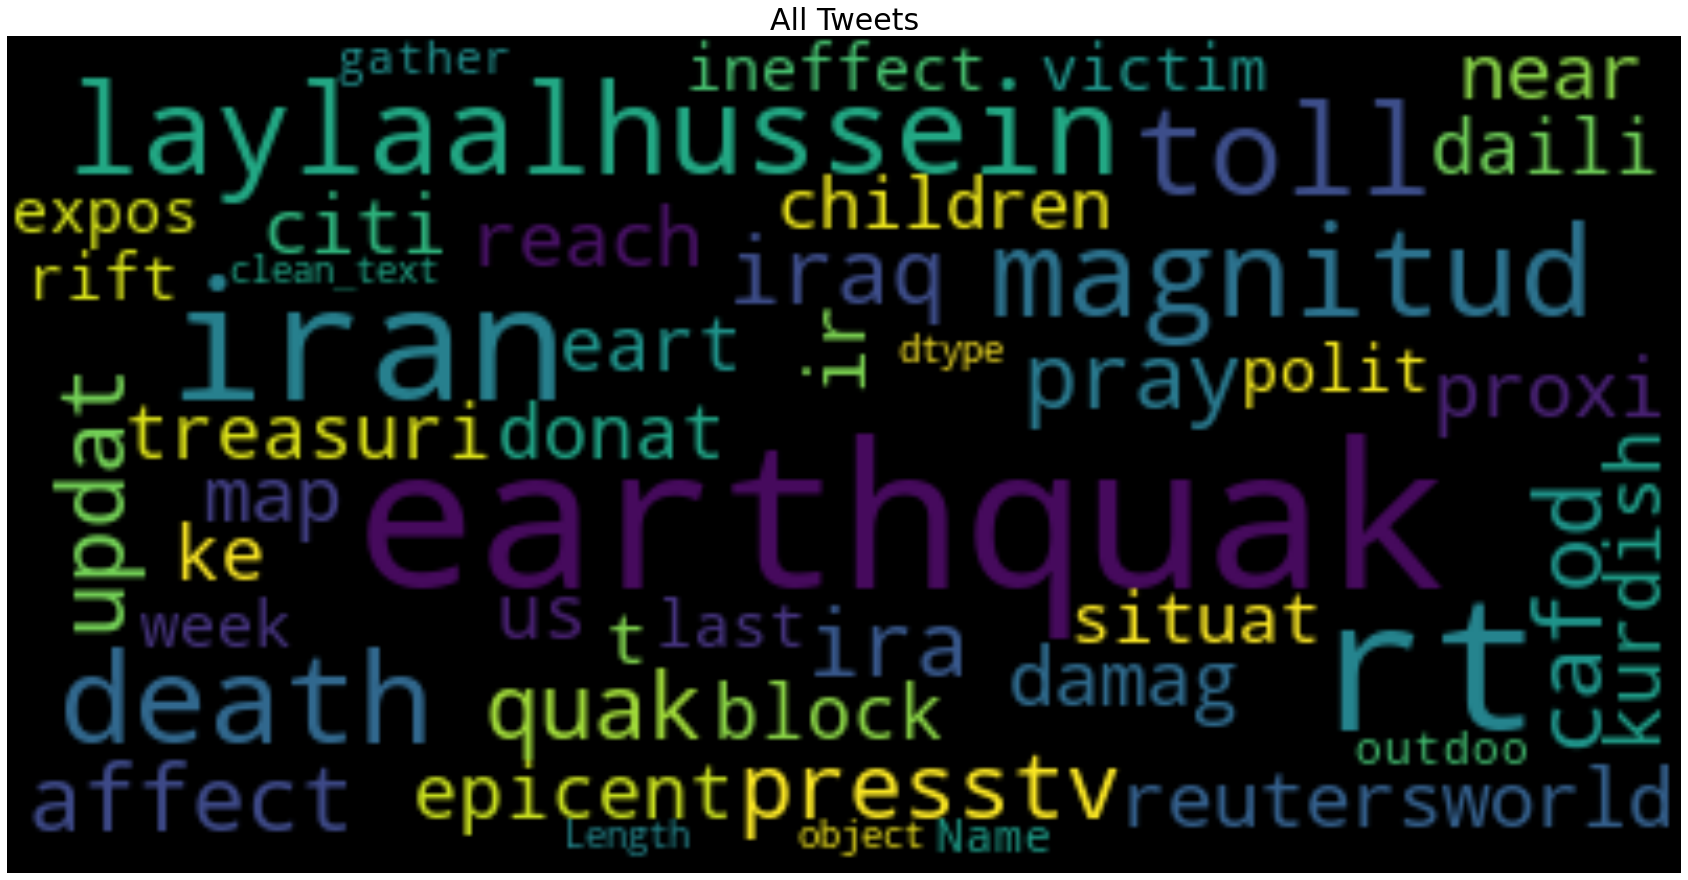

In [28]:
wc = WordCloud(max_font_size=50, max_words=100, background_color="black",stopwords = stopwords).generate(str(twitter['clean_text']))
plt.figure(figsize=(30,30))
plt.imshow(wc, interpolation='bilinear')
plt.title('All Tweets', fontsize=30)
plt.axis('off')

In [29]:
#Appliyng Countvectorizer
countVectorizer = CountVectorizer(analyzer='word') 
countVector = countVectorizer.fit_transform(twitter['tweets'])
print('{} Number of reviews has {} words'.format(countVector.shape[0], countVector.shape[1]))
print(countVectorizer.get_feature_names())
count_vect_df = pd.DataFrame(countVector.toarray(), columns=countVectorizer.get_feature_names())

597 Number of reviews has 2384 words
['000', '01', '02', '02hdd7bzf3', '08', '0ejyamnlks', '0gbzge7sja', '0hjb1am668', '0ivlorsc97', '0jdcfjxopu', '0km', '0p0k8hvkno', '0ttlpqwmsr', '0xhpjz0ojv', '0zbhi2hnkb', '0zsz87lmkr', '100', '11', '12', '13', '130', '14', '15', '1500', '160', '1600', '18pm', '1972', '1dexmg0q3h', '1dtdadosk4', '1iqnixkabb', '1kepxhgu3c', '1mrkmyuoev', '1nxhvy340e', '1st', '1u78wi73du', '1urqtv1uws', '1wgzyuxzu2', '1zcaodc9xh', '200', '2017', '201711_earthquake_irn', '204', '207', '21', '210', '211', '214', '218', '23bm9giy2g', '24', '244jxsxuuh', '249pj5lnxg', '2504', '26', '28', '29', '29fs6ve8lp', '29m3ffuvox', '2iefgpjwvt', '2ipfycxrog', '2ksvtldl5l', '2nd', '2rhsyahtz6', '2sg4vfoxfp', '2tyjkeq4lb', '2x0iaad8fk', '30', '300', '32', '320', '328', '32km', '33', '330', '33km', '341', '350', '372', '38mbh4y3kc', '3agwwzbcpm', '3cid0txj68', '3fer19q6da', '3fpojzgb3d', '3gjeqjtqaj', '3skzbyhphv', '400', '4000', '407', '410', '430', '436', '44hzifiosf', '44km', '450'

In [30]:
# Most Used Words
count = pd.DataFrame(count_vect_df.sum())
countdf = count.sort_values(0,ascending=False).head(20)
countdf[1:20]

,0
https,909
earthquake,578
iran,483
iraq,286
in,255
of,160
the,153
to,145
and,79
from,65


(-0.5, 399.5, 199.5, -0.5)

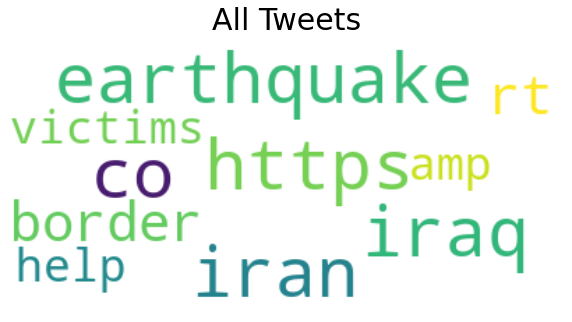

In [31]:
wc = WordCloud(max_font_size=50, max_words=20, background_color="white").generate(str(countdf))
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.title('All Tweets', fontsize=30)
plt.axis('off')